# Library Imports

In [1]:
import os
import sys
import skimage 
import numpy as np
import matplotlib.pyplot as plt
from pygcode import *
from skimage import measure
from skimage import io
from skimage import data
from skimage.color import rgb2gray
from PIL import Image

# Import PNG file

In [2]:
class Contour:
    def __init__(self, start_row, start_col, end_row, end_col):
        self.start_row = start_row
        self.start_col = start_col
        self.end_row = end_row
        self.end_col = end_col
        
    def get_start(self):
        return self.start_row, self.start_col
    
    def get_end(self):
        return self.end_row, self.end_col
        
    def set_start(self, r, c):
        self.start_row = r
        self.start_col = c
    
    def set_end(self, r, c):
        self.end_row = r
        self.end_col = c

In [3]:
class Square:
    def __init__(self, top_left, contours):
        self.case = case
        self.top_left = top_left
        self.contours = contours

In [4]:
def import_image(path):
    file = os.path.join(path)
    img = ""
    try:
        img = io.imread(file)
    except:
        print("File not found")
    return img

In [5]:
#image = import_image("Images/dog.jpg")

# Grayscale Image

In [6]:
def img_to_gray(original):
    grayscale = rgb2gray(original)
    fig, axes = plt.subplots(1, 1, figsize=(4, 4))

    axes.imshow(grayscale, cmap=plt.cm.gray)
    
    fig.tight_layout()
    return grayscale

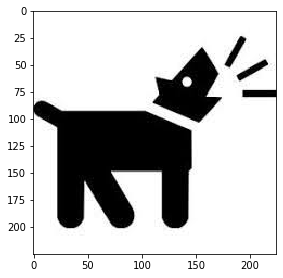

In [7]:
gray_img = img_to_gray(import_image("Images/dog.jpg"))

# Find Contours

In [8]:
def find_contours(image, accuracy):
    img = np.flipud(image)
    
    # Find contours at a constant value defined by parameter accuracy
    contours = measure.find_contours(img, accuracy)
    
    # Display the image and plot all contours found
    fig, ax = plt.subplots()

    for n, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1)

    ax.axis('image')
    plt.show()
    print(contours)
    return contours

In [9]:
#contours = find_contours(gray_img, .3)
#len(contours)

# Naive Approach

In [10]:
def naive_gcode(image, threshold):
    data = img_to_gray(import_image(image))
    
    num_rows = len(data)
    num_cols = len(data[0])
    print(num_rows)
    print(num_cols)
    
    lines = []
    cols = []
                
    for row in range(0, num_rows):
        cols = []
        border = True
        for col in range(0, num_cols): 
            if data[row][col] > threshold:
                if border == False:
                    cols.append(col - 1)
                    border = True
            elif data[row][col] < threshold and border == True:
                cols.append(col)
                border = False
            elif data[row][col] < threshold and col == num_cols-1:
                cols.append(col)
                border = False
        if len(cols) % 2 != 0:
            cols.append(cols[len(cols)-1])
        lines.append(cols)
    
    #Display coords
    i=0
    points = []
    for row in range(0, num_rows):
        for point in lines[i]:
            points.append([i, point])
        i += 1
    
    xs = []
    ys = []
    for coord in points:
        xs.append(coord[1])
        ys.append(coord[0])
    plt.scatter(xs, ys, s = 1)
    plt.show()
    
    lines.reverse()
    return lines

In [11]:
#naive_gcode("Images/gray_test.png", 0.7)

In [12]:
def naive_to_gcode(lines):
    all_instructions = []
    num_rows = len(lines)
    to_coords = lambda coords: {'X': coords[0], 'Y': coords[1]}
    i = 0
    for row in range(0, num_rows):
        for col in lines[row]:
            if i == 0:
                gcode = GCodeRapidMove(**to_coords([col, row]))
                print("%s" % gcode)
                i=1
            else:
                gcode = GCodeLinearMove(**to_coords([col, row]))
                print("%s" % gcode)
                i=0
            all_instructions.append(gcode)
    print(all_instructions)
    return all_instructions

In [13]:
#naive_to_gcode(naive_gcode("Images/gray_test.png", 0.7))

# Marching Squares

In [14]:
def get_case(x):
    return {
        str([0,0,0,0]): 0,
        str([0,0,1,0]): 1,
        str([0,0,0,1]): 2,
        str([0,0,1,1]): 3,
        str([0,1,0,0]): 4,
        str([0,1,1,0]): 5,
        str([0,1,0,1]): 6,
        str([0,1,1,1]): 7,
        str([1,0,0,0]): 8,
        str([1,0,1,0]): 9,
        str([1,0,0,1]): 10,
        str([1,0,1,1]): 11,
        str([1,1,0,0]): 12,
        str([1,1,1,0]): 13,
        str([1,1,0,1]): 14,
        str([1,1,1,1]): 15,
    }.get(x, 16)

In [15]:
get_case(str([0,0,0,0]))

0

In [16]:
def check_corner(data, row, col, threshold):
    corner = 0
    if row >= len(data) and col >= len(data[0]):
        row = len(data)-1
        col = len(data[0])-1
    elif col >= len(data[0]):
        col = len(data[0])-1
    elif row >= len(data):
        row = len(data)-1
    else:
        if data[row][col] > threshold:
            corner = 1
        else:
            corner = 0
    return corner

In [17]:
def check_case(data, row_num, col_num, increment, threshold):
    corners = []
    for row, col in [(row_num+i,col_num+j) for i in (0,increment) for j in (0,increment)]:
        if row < len(data) and col < len(data[0]):
            corners.append(check_corner(data, row, col, threshold))
        elif row >= len(data) and col >= len(data[0]):
            row = len(data)-1
            col = len(data[0])-1
            corners.append(check_corner(data, row, col, threshold))
        elif row >= len(data):
            row = len(data)-1
            corners.append(check_corner(data, row, col, threshold))
        elif col >= len(data[0]):
            col = len(data[0])-1
            corners.append(check_corner(data, row, col, threshold))
    return get_case(str(corners))

In [18]:
def calc_interpolant(val1, val2, threshold, increment):
    interpolant = (val1-threshold)/(val1-val2)
    return np.round(interpolant*5)

In [19]:
def check_square(data, row_num, col_num, increment, threshold):
    case = check_case(data, row_num, col_num, increment, threshold)
    corners = []
    contour = []
    for row, col in [(row_num+i,col_num+j) for i in (0,increment) for j in (0,increment)]:
        if row >= len(data) and col >= len(data[0]):
            row = len(data)-1
            col = len(data[0])-1
        elif col >= len(data[0]):
            col = len(data[0])-1
        elif row >= len(data):
            row = len(data)-1
        corners.append([row, col])
    if case == 1 or case == 14:
        left_interpolant = calc_interpolant(data[corners[0][0]][corners[0][1]], data[corners[2][0]][corners[2][1]], threshold, increment)
        bottom_interpolant = calc_interpolant(data[corners[2][0]][corners[2][1]], data[corners[3][0]][corners[3][1]], threshold, increment)
        contour.append([corners[0][0] + left_interpolant, corners[0][1], corners[2][0], corners[2][1] + bottom_interpolant])
    elif case == 2 or case == 13:
        bottom_interpolant = calc_interpolant(data[corners[2][0]][corners[2][1]], data[corners[3][0]][corners[3][1]], threshold, increment)
        right_interpolant = calc_interpolant(data[corners[1][0]][corners[1][1]], data[corners[3][0]][corners[3][1]], threshold, increment)
        contour.append([corners[2][0], corners[2][1] + bottom_interpolant, corners[1][0] + right_interpolant, corners[1][1]])
    elif case == 3 or case == 12:
        left_interpolant = calc_interpolant(data[corners[0][0]][corners[0][1]], data[corners[2][0]][corners[2][1]], threshold, increment)
        right_interpolant = calc_interpolant(data[corners[1][0]][corners[1][1]], data[corners[3][0]][corners[3][1]], threshold, increment)
        contour.append([corners[0][0] + left_interpolant, corners[0][1], corners[1][0] + right_interpolant, corners[1][1]])
    elif case == 4 or case == 11:
        top_interpolant = calc_interpolant(data[corners[0][0]][corners[0][1]], data[corners[1][0]][corners[1][1]], threshold, increment)
        right_interpolant = calc_interpolant(data[corners[1][0]][corners[1][1]], data[corners[3][0]][corners[3][1]], threshold, increment)
        contour.append([corners[0][0], corners[0][1] + top_interpolant, corners[1][0] + right_interpolant, corners[1][1]])
    elif case == 5 or case == 10:
        top_interpolant = calc_interpolant(data[corners[0][0]][corners[0][1]], data[corners[1][0]][corners[1][1]], threshold, increment)
        left_interpolant = calc_interpolant(data[corners[0][0]][corners[0][1]], data[corners[2][0]][corners[2][1]], threshold, increment)
        bottom_interpolant = calc_interpolant(data[corners[2][0]][corners[2][1]], data[corners[3][0]][corners[3][1]], threshold, increment)
        right_interpolant = calc_interpolant(data[corners[1][0]][corners[1][1]], data[corners[3][0]][corners[3][1]], threshold, increment)
        contour.append([corners[0][0], corners[0][1] + top_interpolant, corners[0][0] + left_interpolant, corners[0][1]])
        contour.append([corners[2][0], corners[2][1] + bottom_interpolant, corners[1][0] + right_interpolant, corners[1][1]])
    elif case == 6 or case == 9:
        top_interpolant = calc_interpolant(data[corners[0][0]][corners[0][1]], data[corners[1][0]][corners[1][1]], threshold, increment)
        bottom_interpolant = calc_interpolant(data[corners[2][0]][corners[2][1]], data[corners[3][0]][corners[3][1]], threshold, increment)
        contour.append([corners[0][0], corners[0][1] + top_interpolant, corners[2][0], corners[2][1] + bottom_interpolant])
    elif case == 7 or case == 8:
        top_interpolant = calc_interpolant(data[corners[0][0]][corners[0][1]], data[corners[1][0]][corners[1][1]], threshold, increment)
        left_interpolant = calc_interpolant(data[corners[0][0]][corners[0][1]], data[corners[2][0]][corners[2][1]], threshold, increment)
        contour.append([corners[0][0], corners[0][1] + top_interpolant, corners[0][0] + left_interpolant, corners[0][1]])
    return contour

In [20]:
print(check_case(gray_img, 145, 140, 5, 0.7))
print(check_square(gray_img, 145, 140, 5, 0.7))

2
[[150, 143.0, 148.0, 145]]


In [21]:
def get_reference_squares(data, threshold, increment):#
    references = []
    num_rows = len(data)
    num_cols = len(data[0])
    important_squares = []
    print(str(num_rows) + "x" + str(num_cols))
    for row in range(0, num_rows, increment):
        for col in range(0, num_cols, increment):
            if check_case(data, row, col, increment, threshold) != 15 and check_case(data, row, col, increment, threshold) != 0:
                important_squares.append([row, col])
    plt.imshow(data, cmap="gray")
    xs = [x[1] for x in important_squares]
    ys = [x[0] for x in important_squares]
    plt.scatter(xs, ys, 0.5)
    plt.show()
    return important_squares

360x360


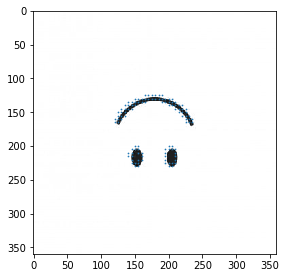

[[125, 165],
 [125, 170],
 [125, 175],
 [125, 180],
 [125, 185],
 [125, 190],
 [130, 150],
 [130, 155],
 [130, 160],
 [130, 165],
 [130, 170],
 [130, 175],
 [130, 180],
 [130, 185],
 [130, 190],
 [130, 195],
 [130, 200],
 [130, 205],
 [135, 140],
 [135, 145],
 [135, 150],
 [135, 155],
 [135, 160],
 [135, 165],
 [135, 190],
 [135, 195],
 [135, 200],
 [135, 205],
 [135, 210],
 [140, 135],
 [140, 140],
 [140, 145],
 [140, 150],
 [140, 200],
 [140, 205],
 [140, 210],
 [140, 215],
 [140, 220],
 [145, 130],
 [145, 135],
 [145, 140],
 [145, 145],
 [145, 210],
 [145, 215],
 [145, 220],
 [145, 225],
 [150, 125],
 [150, 130],
 [150, 135],
 [150, 215],
 [150, 220],
 [150, 225],
 [155, 125],
 [155, 130],
 [155, 135],
 [155, 220],
 [155, 225],
 [155, 230],
 [160, 120],
 [160, 125],
 [160, 130],
 [160, 225],
 [160, 230],
 [160, 235],
 [165, 120],
 [165, 125],
 [165, 225],
 [165, 230],
 [165, 235],
 [200, 150],
 [200, 155],
 [200, 200],
 [200, 205],
 [205, 145],
 [205, 150],
 [205, 155],
 [205, 195],

In [31]:
get_reference_squares(np.flipud(img_to_gray(import_image("Images/smile.png"))), .5, 5)

In [23]:
def get_ms_contours(filename, threshold, increment, marker_size):
    data = np.flipud(img_to_gray(import_image(filename)))
    references = get_reference_squares(data, threshold, increment)
    x = []
    y = []
    squares = []
    contours = []
    for coord in references:
        square = check_square(data, coord[0], coord[1], increment, threshold)
        print(square)
        contours.append(square)
    return contours

752x748


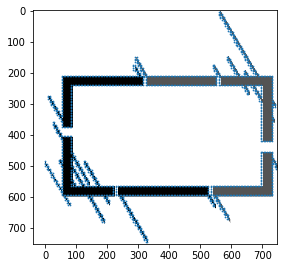

[[10, 564.0, 9.0, 565]]
[[9.0, 565, 10, 566.0]]
[[10, 564.0, 15, 564.0]]
[[10, 566.0, 14.0, 570]]
[[14.0, 570, 15, 571.0]]
[[15, 564.0, 16.0, 565]]
[[16.0, 565, 20, 569.0]]
[[15, 571.0, 20, 571.0]]
[[20, 569.0, 25, 569.0]]
[[20, 571.0, 24.0, 575]]
[[24.0, 575, 25, 576.0]]
[[25, 569.0, 26.0, 570]]
[[26.0, 570, 30, 574.0]]
[[25, 576.0, 30, 576.0]]
[[30, 574.0, 32.0, 575]]
[[30, 576.0, 32.0, 575], [35, 578.0, 34.0, 580]]
[[34.0, 580, 35, 581.0]]
[[35, 578.0, 40, 579.0]]
[[35, 581.0, 40, 584.0]]
[[40, 579.0, 41.0, 580]]
[[40, 584.0, 41.0, 580], [45, 584.0, 41.0, 585]]
[[41.0, 585, 45, 586.0]]
[[45, 584.0, 50, 584.0]]
[[45, 586.0, 49.0, 590]]
[[49.0, 590, 50, 591.0]]
[[50, 584.0, 51.0, 585]]
[[51.0, 585, 55, 589.0]]
[[50, 591.0, 55, 591.0]]
[[55, 589.0, 58.0, 590]]
[[55, 591.0, 58.0, 590], [60, 592.0, 59.0, 595]]
[[59.0, 595, 60, 596.0]]
[[60, 592.0, 65, 594.0]]
[[60, 596.0, 65, 597.0]]
[[65, 594.0, 66.0, 595]]
[[65, 597.0, 66.0, 595], [70, 599.0, 68.0, 600]]
[[68.0, 600, 70, 601.0]]
[[70, 

In [32]:
print(get_ms_contours("Images/gray_test.png", .7, 5, 5))

In [25]:
def ms_to_GCode(squares):
    i = 0
    all_instructions = []
    to_coords = lambda coords: {'X': coords[1], 'Y': coords[0]}
    for contours in squares:
        for contour in contours:
            initial_coords = [contour[0], contour[1]]
            final_coords = [contour[2], contour[3]]
            initial_coords_gcode = GCodeRapidMove(**to_coords(initial_coords))
            final_coords_gcode = GCodeLinearMove(**to_coords(final_coords))
            all_instructions.append(initial_coords_gcode)
            all_instructions.append(final_coords_gcode)
    return all_instructions

225x225


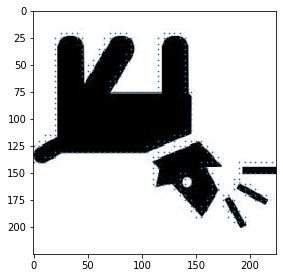

[[25, 26.0, 22.0, 30]]
[[22.0, 30, 22.0, 35]]
[[22.0, 35, 22.0, 40]]
[[22.0, 40, 25, 43.0]]
[[25, 72.0, 22.0, 75]]
[[22.0, 75, 22.0, 80]]
[[22.0, 80, 21.0, 85]]
[[21.0, 85, 25, 89.0]]
[[25, 121.0, 22.0, 125]]
[[22.0, 125, 21.0, 130]]
[[21.0, 130, 22.0, 135]]
[[22.0, 135, 25, 139.0]]
[[30, 21.0, 26.0, 25]]
[[25, 26.0, 26.0, 25]]
[[25, 43.0, 27.0, 45]]
[[27.0, 45, 30, 48.0]]
[[30, 67.0, 27.0, 70]]
[[25, 72.0, 27.0, 70]]
[[25, 89.0, 26.0, 90]]
[[26.0, 90, 30, 94.0]]
[[30, 117.0, 27.0, 120]]
[[25, 121.0, 27.0, 120]]
[[25, 139.0, 26.0, 140]]
[[26.0, 140, 30, 144.0]]
[[30, 21.0, 35, 21.0]]
[[30, 48.0, 35, 49.0]]
[[30, 67.0, 35, 67.0]]
[[30, 94.0, 35, 93.0]]
[[30, 117.0, 35, 116.0]]
[[30, 144.0, 35, 144.0]]
[[35, 21.0, 40, 21.0]]
[[35, 49.0, 40, 49.0]]
[[40, 61.0, 37.0, 65]]
[[35, 67.0, 37.0, 65]]
[[35, 93.0, 40, 94.0]]
[[35, 116.0, 40, 116.0]]
[[35, 144.0, 40, 144.0]]
[[40, 21.0, 45, 22.0]]
[[40, 49.0, 45, 49.0]]
[[40, 61.0, 45, 61.0]]
[[45, 89.0, 44.0, 90]]
[[40, 94.0, 44.0, 90]]
[[40, 116.

In [26]:
gcodes = ms_to_GCode(get_ms_contours("Images/dog.jpg", .7, 5, 1))
print(gcodes)

# Output GCODE to file

In [27]:
def output_gcode(all_instructions, filename):
    File_object = open(filename,"w")
    for gcode in all_instructions:
        print(gcode)
        File_object.write(str(gcode) + ";\n")
    File_object.close()

In [28]:
#output_gcode(naive_to_gcode(naive_gcode("Images/smile.png", 0.7)), "output2.gcode")

752x748


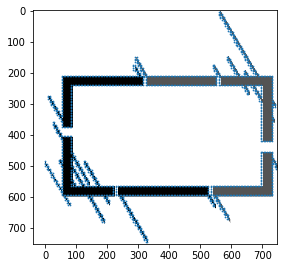

[[10, 564.0, 9.0, 565]]
[[9.0, 565, 10, 566.0]]
[[10, 564.0, 15, 564.0]]
[[10, 566.0, 14.0, 570]]
[[14.0, 570, 15, 571.0]]
[[15, 564.0, 16.0, 565]]
[[16.0, 565, 20, 569.0]]
[[15, 571.0, 20, 571.0]]
[[20, 569.0, 25, 569.0]]
[[20, 571.0, 24.0, 575]]
[[24.0, 575, 25, 576.0]]
[[25, 569.0, 26.0, 570]]
[[26.0, 570, 30, 574.0]]
[[25, 576.0, 30, 576.0]]
[[30, 574.0, 32.0, 575]]
[[30, 576.0, 32.0, 575], [35, 578.0, 34.0, 580]]
[[34.0, 580, 35, 581.0]]
[[35, 578.0, 40, 579.0]]
[[35, 581.0, 40, 584.0]]
[[40, 579.0, 41.0, 580]]
[[40, 584.0, 41.0, 580], [45, 584.0, 41.0, 585]]
[[41.0, 585, 45, 586.0]]
[[45, 584.0, 50, 584.0]]
[[45, 586.0, 49.0, 590]]
[[49.0, 590, 50, 591.0]]
[[50, 584.0, 51.0, 585]]
[[51.0, 585, 55, 589.0]]
[[50, 591.0, 55, 591.0]]
[[55, 589.0, 58.0, 590]]
[[55, 591.0, 58.0, 590], [60, 592.0, 59.0, 595]]
[[59.0, 595, 60, 596.0]]
[[60, 592.0, 65, 594.0]]
[[60, 596.0, 65, 597.0]]
[[65, 594.0, 66.0, 595]]
[[65, 597.0, 66.0, 595], [70, 599.0, 68.0, 600]]
[[68.0, 600, 70, 601.0]]
[[70, 

G01 X550 Y196
G00 X550 Y196
G01 X554 Y200
G00 X556 Y195
G01 X556 Y200
G00 X611 Y195
G01 X614 Y200
G00 X616 Y195
G01 X617 Y200
G00 X644 Y200
G01 X645 Y199
G00 X645 Y199
G01 X646 Y200
G00 X672 Y195
G01 X674 Y200
G00 X676 Y195
G01 X677 Y200
G00 X297 Y200
G01 X298 Y205
G00 X302 Y200
G01 X305 Y203
G00 X305 Y203
G01 X307 Y205
G00 X318 Y200
G01 X319 Y205
G00 X321 Y200
G01 X325 Y205
G00 X554 Y200
G01 X554 Y205
G00 X556 Y200
G01 X560 Y204
G00 X560 Y204
G01 X561 Y205
G00 X614 Y200
G01 X615 Y201
G00 X617 Y200
G01 X615 Y201
G00 X619 Y205
G01 X620 Y203
G00 X620 Y203
G01 X621 Y205
G00 X644 Y200
G01 X644 Y205
G00 X646 Y200
G01 X650 Y204
G00 X650 Y204
G01 X651 Y205
G00 X674 Y200
G01 X675 Y201
G00 X677 Y200
G01 X675 Y201
G00 X679 Y205
G01 X680 Y203
G00 X680 Y203
G01 X681 Y205
G00 X298 Y205
G01 X300 Y207
G00 X300 Y207
G01 X303 Y210
G00 X307 Y205
G01 X307 Y210
G00 X319 Y205
G01 X320 Y206
G00 X325 Y205
G01 X320 Y206
G00 X324 Y210
G01 X325 Y205
G00 X325 Y205
G01 X326 Y210
G00 X554 Y205
G01 X555 Y206
G00 X5

In [35]:
output_gcode(ms_to_GCode(get_ms_contours("Images/gray_test.png", .7, 5, 1)), "output.gcode")